In [1]:
import itk
import matplotlib.pyplot as plt
import vtk
import numpy as np

In [2]:
layer = 80

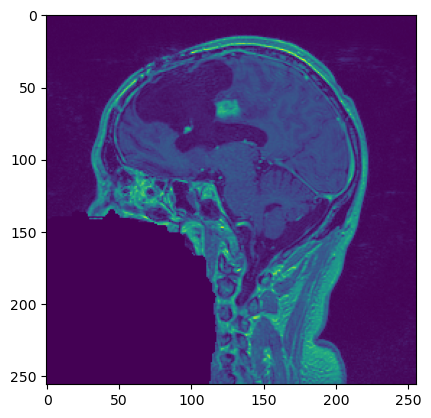

In [3]:
image = itk.imread("Data/case6_gre1.nrrd", itk.F)
plt.imshow(image[layer])

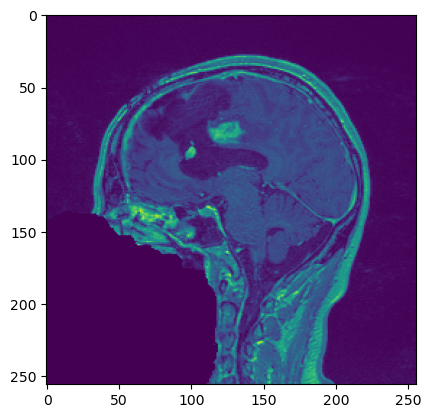

In [4]:
image2 = itk.imread("Data/case6_gre2.nrrd", itk.F)
plt.imshow(image2[layer])

In [5]:
def Recalage(fixed, moving):

    fixed_image = itk.imread(fixed, itk.F)
    moving_image = itk.imread(moving, itk.F)

    type_ = type(fixed_image)
    outType_ = itk.Image[itk.F, 3]
    
    registration_method = itk.ImageRegistrationMethodv4[type_, type_].New()
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)
    
    transform_type = itk.TranslationTransform[itk.D, 3].New()
    transform_type.SetIdentity()
    registration_method.SetInitialTransform(transform_type)

    metric = itk.MeanSquaresImageToImageMetricv4[type_, type_].New()
    metric.SetFixedImage(fixed_image)
    metric.SetMovingImage(moving_image)

    registration_method.SetMetric(metric)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
    optimizer.SetLearningRate(4.0)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(5)
    print(optimizer.GetValue())
    registration_method.SetOptimizer(optimizer)
    
    registration_method.Update()
    final_transform = registration_method.GetTransform()
    
    resampler = itk.ResampleImageFilter[type_, type_].New()
    resampler.SetInput(moving_image)
    resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputOrigin(fixed_image.GetOrigin())
    resampler.SetOutputSpacing(fixed_image.GetSpacing())
    resampler.SetOutputDirection(fixed_image.GetDirection())
    resampler.SetTransform(final_transform)

    resampler.Update()
    resampled_image = resampler.GetOutput()

    cast_filter = itk.CastImageFilter[type_, outType_].New()
    cast_filter.SetInput(resampled_image)
    cast_filter.Update()
    return cast_filter.GetOutput()

In [6]:
recalee = Recalage("Data/case6_gre1.nrrd", "Data/case6_gre2.nrrd")

0.0


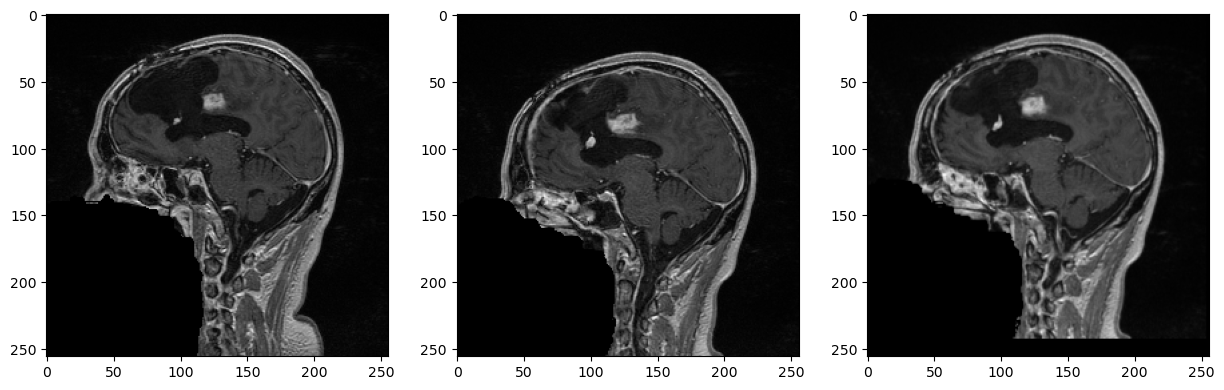

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image[layer], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(image2[layer], cmap="gray")
plt.subplot(1,3,3)
plt.imshow(recalee[layer], cmap="gray")

In [8]:
"""def RecalageBSpline(fixed, moving):
    fixed_image = itk.imread(fixed, itk.F)
    moving_image = itk.imread(moving, itk.F)

    type_ = type(fixed_image)
    outType_ = itk.Image[itk.F, 3]

    registration_method = itk.ImageRegistrationMethodv4[type_, type_].New()
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)

    transform_type = itk.BSplineTransform[itk.D, 3, 3].New()
    transform_type.SetIdentity()
    registration_method.SetInitialTransform(transform_type)

    metric = itk.MeanSquaresImageToImageMetricv4[type_, type_].New()
    metric.SetFixedImage(fixed_image)
    metric.SetMovingImage(moving_image)

    registration_method.SetMetric(metric)

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
    optimizer.SetLearningRate(4.0)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(2)
    registration_method.SetOptimizer(optimizer)

    registration_method.Update()
    final_transform = registration_method.GetTransform()

    resampler = itk.ResampleImageFilter[type_, type_].New()
    resampler.SetInput(moving_image)
    resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputOrigin(fixed_image.GetOrigin())
    resampler.SetOutputSpacing(fixed_image.GetSpacing())
    resampler.SetOutputDirection(fixed_image.GetDirection())
    resampler.SetTransform(final_transform)

    resampler.Update()
    resampled_image = resampler.GetOutput()

    cast_filter = itk.CastImageFilter[type_, outType_].New()
    cast_filter.SetInput(resampled_image)
    cast_filter.Update()
    return cast_filter.GetOutput()
recaleeBspline = RecalageBSpline("Data/case6_gre1.nrrd", "Data/case6_gre2.nrrd")
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image[layer])
plt.subplot(1,3,2) 
plt.imshow(image2[layer])
plt.subplot(1,3,3)
plt.imshow(recaleeBspline[layer])"""

'def RecalageBSpline(fixed, moving):\n    fixed_image = itk.imread(fixed, itk.F)\n    moving_image = itk.imread(moving, itk.F)\n\n    type_ = type(fixed_image)\n    outType_ = itk.Image[itk.F, 3]\n\n    registration_method = itk.ImageRegistrationMethodv4[type_, type_].New()\n    registration_method.SetFixedImage(fixed_image)\n    registration_method.SetMovingImage(moving_image)\n\n    transform_type = itk.BSplineTransform[itk.D, 3, 3].New()\n    transform_type.SetIdentity()\n    registration_method.SetInitialTransform(transform_type)\n\n    metric = itk.MeanSquaresImageToImageMetricv4[type_, type_].New()\n    metric.SetFixedImage(fixed_image)\n    metric.SetMovingImage(moving_image)\n\n    registration_method.SetMetric(metric)\n\n    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()\n    optimizer.SetLearningRate(4.0)\n    optimizer.SetMinimumStepLength(0.001)\n    optimizer.SetNumberOfIterations(2)\n    registration_method.SetOptimizer(optimizer)\n\n    registration_method.U

In [9]:
#Segmentation

def segmentation(img, seedX, seedY, seedZ, lower, upper):
    type_ = type(img)
        
    filter_ = itk.GradientAnisotropicDiffusionImageFilter[type_, type_].New()
    filter_.SetInput(img) 
    output_image = filter_.GetOutput()

    connected_threshold_filter = itk.ConnectedThresholdImageFilter[type_, type_].New()
    connected_threshold_filter.SetInput(output_image)
    seed = itk.Index[3]()
    seed[0] = seedX
    seed[1] = seedY
    seed[2] = seedZ
    connected_threshold_filter.SetSeed(seed)
    connected_threshold_filter.Update()
    connected_threshold_filter.SetLower(lower)
    connected_threshold_filter.SetUpper(upper)
    connected_threshold_filter.SetReplaceValue(255)
    output_image = connected_threshold_filter.GetOutput()

    rescaleIntensityFilter = itk.RescaleIntensityImageFilter[type_, type_].New()
    rescaleIntensityFilter.SetInput(output_image)
    rescaleIntensityFilter.SetOutputMinimum(0)
    rescaleIntensityFilter.SetOutputMaximum(255)
    rescaleIntensityFilter.Update()

    out = itk.rescale_intensity_image_filter(output_image, output_minimum=0)

    return out

In [10]:
segmented_before = segmentation(image, 125, 65, 80, 600, 800)

In [11]:
segmented_after = segmentation(recalee, 125, 65, 80, 600, 800)

overflow encountered in multiply


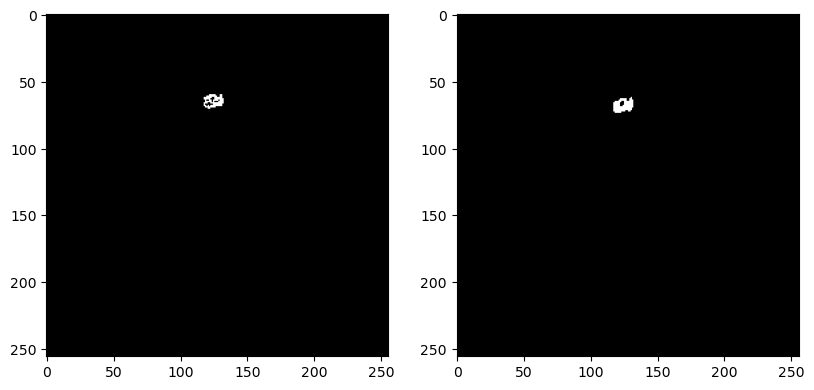

In [12]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(segmented_before[layer], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(segmented_after[layer], cmap="gray")

In [13]:
def count_white_pixels(image):
    array_view = itk.GetArrayViewFromImage(image)
    array = np.array(array_view, copy=True)
    white_pixels = np.sum(array == 255)
    return white_pixels

In [14]:
white_pixels_tumor1 = count_white_pixels(segmented_before)
white_pixels_tumor2 = count_white_pixels(segmented_after)
print(white_pixels_tumor1)
print(white_pixels_tumor2)

0
0


In [15]:
def compute_tumor_volume(image):
    image_type = type(image)
    statistics_filter = itk.StatisticsImageFilter[image_type].New()
    statistics_filter.SetInput(image)
    statistics_filter.Update()

    # Get the volume of a voxel
    voxel_volume = image.GetSpacing()[0] * image.GetSpacing()[1] * image.GetSpacing()[2]
    tumor_volume = statistics_filter.GetSum() * voxel_volume

    return tumor_volume

In [16]:
compute_tumor_volume(segmented_before)

3.879218751679229e+41

In [17]:
compute_tumor_volume(segmented_after)

4.209292627918602e+41

In [18]:
compute_tumor_volume(image)

1508346814.0

In [19]:
itk.imwrite(segmented_before, "Data/segmented.nrrd")
itk.imwrite(segmented_after, "Data/segmented2.nrrd")

In [26]:
class CustomInteractorStyle(vtk.vtkInteractorStyleTrackballCamera):
    def __init__(self, mapper1, mapper2, actor1, actor2):
        self.mapper1 = mapper1
        self.mapper2 = mapper2
        self.actor1 = actor1
        self.actor2 = actor2
        self.current_mapper = self.mapper1
        self.AddObserver("KeyPressEvent", self.onKeyPress)
        self.actor1.VisibilityOff()
        self.actor2.VisibilityOff()

    def onKeyPress(self, obj, event):
        key = self.GetInteractor().GetKeySym()
        # Show the tumor before
        if key == "b":
            if self.current_mapper == self.mapper1:
                self.current_mapper = self.mapper2
                self.actor2.VisibilityOn()
            else:
                self.current_mapper = self.mapper1
                self.actor2.VisibilityOff()
            self.GetInteractor().Render()
        # Show the tumor after
        if key == "a":
            if self.current_mapper == self.mapper1:
                self.current_mapper = self.mapper2
                self.actor1.VisibilityOn()
            else:
                self.current_mapper = self.mapper1
                self.actor1.VisibilityOff()
            self.GetInteractor().Render()

head_scan = itk.vtk_image_from_image(itk.imread('Data/case6_gre1.nrrd'))
tumor_1_scan = itk.vtk_image_from_image(itk.imread('Data/segmented.nrrd'))
tumor_2_scan = itk.vtk_image_from_image(itk.imread('Data/segmented2.nrrd'))

# Create volume properties and mappers
mapper2 = vtk.vtkSmartVolumeMapper()
mapper2.SetInputData(head_scan)

opacity_transfer_function = vtk.vtkPiecewiseFunction()
opacity_transfer_function.AddPoint(0.0, 0.0)
opacity_transfer_function.AddPoint(90.0, 0.0)
opacity_transfer_function.AddPoint(100.0, 0.2)
opacity_transfer_function.AddPoint(120.0, 0.0)

colorFun = vtk.vtkColorTransferFunction()
colorFun.AddRGBPoint(0, 1, 1, 1)

volume_property = vtk.vtkVolumeProperty()
volume_property.SetColor(colorFun)
volume_property.SetScalarOpacity(opacity_transfer_function)

# Create volume actor and set transforms
volume = vtk.vtkVolume()
volume.SetMapper(mapper2)
volume.SetProperty(volume_property)

matrix = head_scan.GetPhysicalToIndexMatrix()
transf = vtk.vtkTransform()
transf.Translate(itk.dict_from_image(itk.imread('Data/case6_gre1.nrrd'))["origin"])
transf.PostMultiply()
transf.Concatenate(volume.GetMatrix())
volume.SetUserTransform(transf)

transf = vtk.vtkTransform()
transf.SetMatrix(matrix)
transf.PostMultiply()
transf.Concatenate(volume.GetMatrix())
volume.SetUserTransform(transf)

# Create contour filters, mappers, and actors for img[1] and img[2]
tumor1 = vtk.vtkContourFilter()
tumor1.SetInputData(tumor_1_scan)
tumor1.GenerateValues(1, 135, 135)

tumor2 = vtk.vtkContourFilter()
tumor2.SetInputData(tumor_2_scan)
tumor2.GenerateValues(1, 135, 135)

mapper1 = vtk.vtkDataSetMapper()
mapper1.SetInputConnection(tumor1.GetOutputPort())
mapper1.SetScalarVisibility(False)

actor1 = vtk.vtkActor()
actor1.SetMapper(mapper1)
actor1.GetProperty().SetColor(1, 0.5, 0)

mapper2 = vtk.vtkDataSetMapper()
mapper2.SetInputConnection(tumor2.GetOutputPort())
mapper2.SetScalarVisibility(False)

actor2 = vtk.vtkActor()
actor2.SetMapper(mapper2)
actor2.GetProperty().SetColor(1, 0, 0)
actor2.VisibilityOff()

# Create the renderer, render window, and interactor
renderer = vtk.vtkRenderer()
renderer.AddActor(actor1)
renderer.AddActor(actor2)
renderer.AddVolume(volume)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 600)
render_window.Render()

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Set the custom interactor style
custom_style = CustomInteractorStyle(mapper1, mapper2, actor1, actor2)
interactor.SetInteractorStyle(custom_style)

interactor.Start()